In [150]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt


conn_deliveroo = sqlite3.connect(r'../databases/deliveroo.db')
conn_takeaway = sqlite3.connect(r'../databases/takeaway.db')
conn_ubereats = sqlite3.connect(r'../databases/ubereats.db')  

### What is the distribution of restaurants per location?
### Compare restaurant distributions across UberEats, Deliveroo, and Takeaway. What are some of the market trends


<Figure size 1200x600 with 0 Axes>

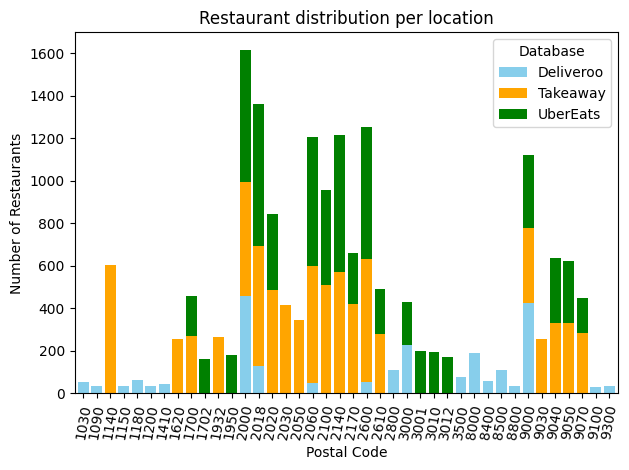

In [151]:

# Query for deliveroo 
query_deliveroo = """
SELECT res.postal_code as postal_code, COUNT(distinct res.id) AS restaurant_count
FROM locations_to_restaurants ltr
JOIN restaurants res on res.id = ltr.restaurant_id
JOIN locations l on l.id = ltr.location_id
GROUP BY postal_code
ORDER BY restaurant_count DESC
Limit 20;
"""

# Query for takeaway
query_takeaway = """
SELECT l.postalCode as postal_code, COUNT(distinct res.primarySlug) AS restaurant_count
FROM locations_to_restaurants ltr
JOIN locations l ON l.id = ltr.location_id
JOIN restaurants res on res.primarySlug = ltr.restaurant_id
GROUP BY l.postalCode
ORDER BY restaurant_count DESC
Limit 20;
"""

# Query for ubereats
query_ubereats = """
SELECT l.region as postal_code, COUNT(distinct res.id) AS restaurant_count
FROM locations_to_restaurants ltr
JOIN locations l on l.id = ltr.location_id
JOIN restaurants res on res.id = ltr.restaurant_id
GROUP BY postal_code
ORDER BY restaurant_count DESC
Limit 20;
"""

deliveroo_data = pd.read_sql_query(query_deliveroo, conn_deliveroo)
takeaway_data = pd.read_sql_query(query_takeaway, conn_takeaway)
ubereats_data = pd.read_sql_query(query_ubereats, conn_ubereats)


# Add a source column to each DataFrame to differentiate between the databases
deliveroo_data['source'] = 'Deliveroo'
takeaway_data['source'] = 'Takeaway'
ubereats_data['source'] = 'UberEats'

# get city names from takeaway db
query_city_mapping = """
SELECT city, postalCode as postal_code FROM locations;
"""
city_mapping_df = pd.read_sql_query(query_city_mapping, conn_takeaway)

# mapping of postal codes to city names - not work correctly TO BE DONE later!
postal_code_to_city = dict(zip(city_mapping_df['postal_code'], city_mapping_df['city']))

conn_deliveroo.close()
conn_takeaway.close()
conn_ubereats.close()

# Combine all and Map the postal codes to cities for all datasets
combined_data = pd.concat([deliveroo_data, takeaway_data, ubereats_data])
combined_data['postal_code'] = combined_data['postal_code'].astype(str)
combined_data['city'] = combined_data['postal_code'].map(postal_code_to_city).fillna(combined_data['postal_code'])
pivot_data = combined_data.pivot_table(index='city', columns='source', values='restaurant_count', aggfunc='sum', fill_value=0)


plt.figure(figsize=(12, 6))
ax = pivot_data.plot(kind='bar', stacked=True, color=['skyblue', 'orange', 'green'], width=0.8)
plt.xlabel('Postal Code')
plt.ylabel('Number of Restaurants')
plt.title('Restaurant distribution per location')
plt.xticks(rotation=80)
plt.legend(title="Database")
plt.tight_layout()
plt.show()


### Conclusion

- **Antwerp** and **Ghent (Destelbergen**) stand out as having the highest count of restaurants, showcasing the food delivery market across all platforms for these cities.

- Certain cities like **Ostend**, **Bruges**, **Kortrijk**, **Mechelen**, **Sint-Niklaas**, and **Aalst** are commonly serviced by Deliveroo alone, with no presence from the other platforms and having lower count of restaurants comparing to other cities.

- Cities such as **Brussels (Evere)** and **Drogenbos** feature Takeaway as the exclusive delivery service.

- Interestingly, **Leuven** appears to be fully served by UberEats, as indicated by the strong green color in the plot, with no data for other delivery services.

### Next step to show geo map for these findings

In [ ]:
#import json
#import contextily as cx
#import geopandas as gpd
